In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date
import calendar

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
## Are flights more likely to be delayed during a specific part of the day?

def get_flights_by_hour_of_departure(year=2017):
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        hour_of_departure = pd.read_sql("""
            SELECT 
                strftime('%H',f.departure_time_scheduled) AS departure_hour,
                SUM(f.flights) AS flight_count,
                SUM(f.departure_was_delayed_15) AS flights_delayed
            FROM 
                flights AS f
            WHERE 
                f.year = :year 
            GROUP BY 
                departure_hour
        """, conn, 
        params={'year': year})
        hour_of_departure['fraction_delayed'] = hour_of_departure['flights_delayed'] / hour_of_departure['flight_count']
    return hour_of_departure

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
hour_of_departure = get_flights_by_hour_of_departure()
hour_of_departure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
departure_hour      24 non-null object
flight_count        24 non-null int64
flights_delayed     24 non-null int64
fraction_delayed    24 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 848.0+ bytes


In [3]:
hour_of_departure.flight_count.sum()

5674621

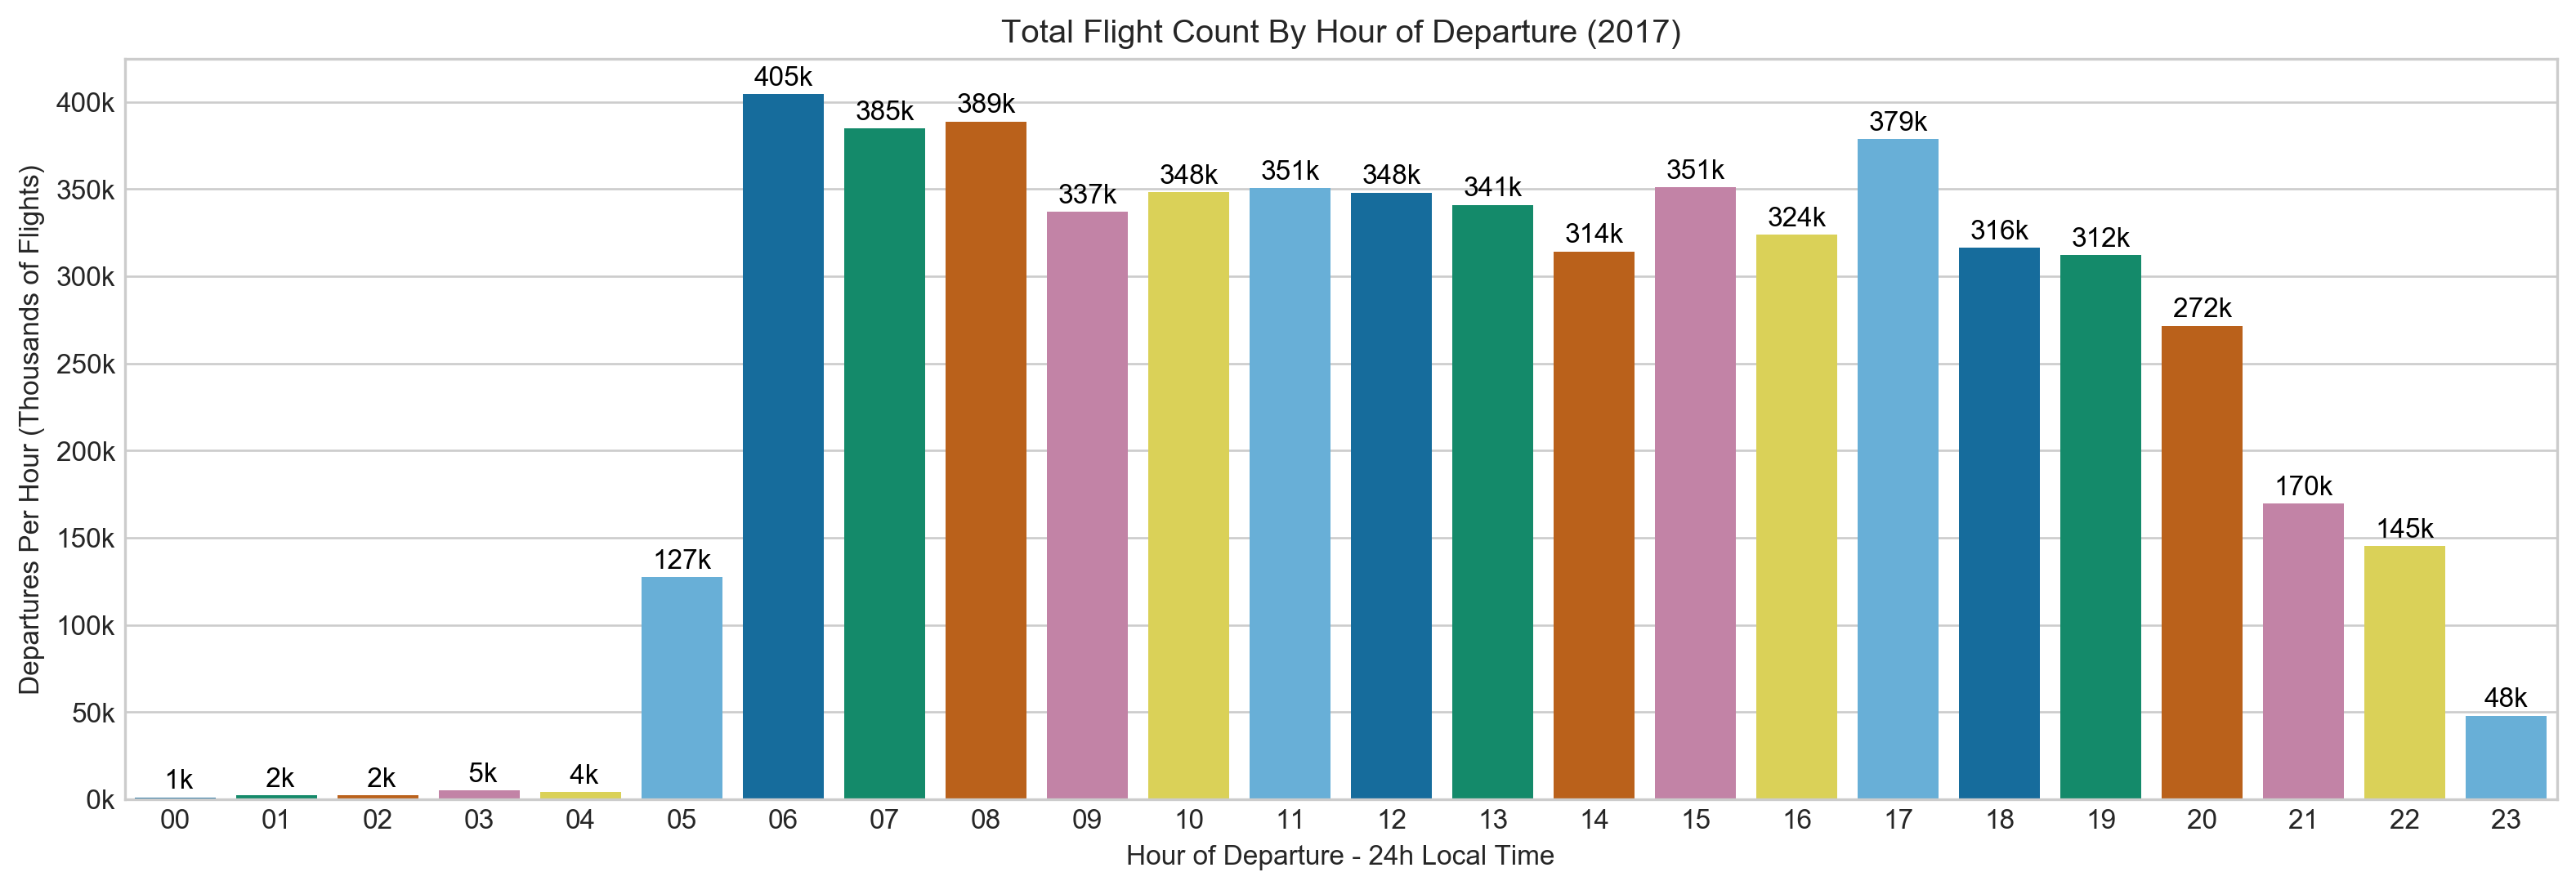

In [4]:
def plot_flights_by_hour_of_departure(data):
    """Generate a bar plot showing the flight counts by hour of departure in local time
    
        Note: Hour of Departure is assumed to be on a 24 hour clock
    """
    color = sns.color_palette('colorblind')
    fig, ax = plt.subplots(figsize=(16, 5), dpi=240)
    ax = sns.barplot(ax=ax, x='departure_hour', y='flight_count', data=data, palette=color)

    thousands = 1e3

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:2.0f}k'.format(x / thousands) for x in vals])

    for p in ax.patches:
        height = p.get_height()
        label_string = '{:2.0f}k'.format(height / thousands)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 5e3,
                label_string,
                ha="center", color='black') 

    plt.title('Total Flight Count By Hour of Departure (2017)')
    plt.xlabel('Hour of Departure - 24h Local Time')
    plt.ylabel('Departures Per Hour (Thousands of Flights)')
    plt.savefig("../../reports/figures/flights-by-hour-of-departure.png", bbox_inches='tight')
    plt.show()
    
plot_flights_by_hour_of_departure(hour_of_departure)

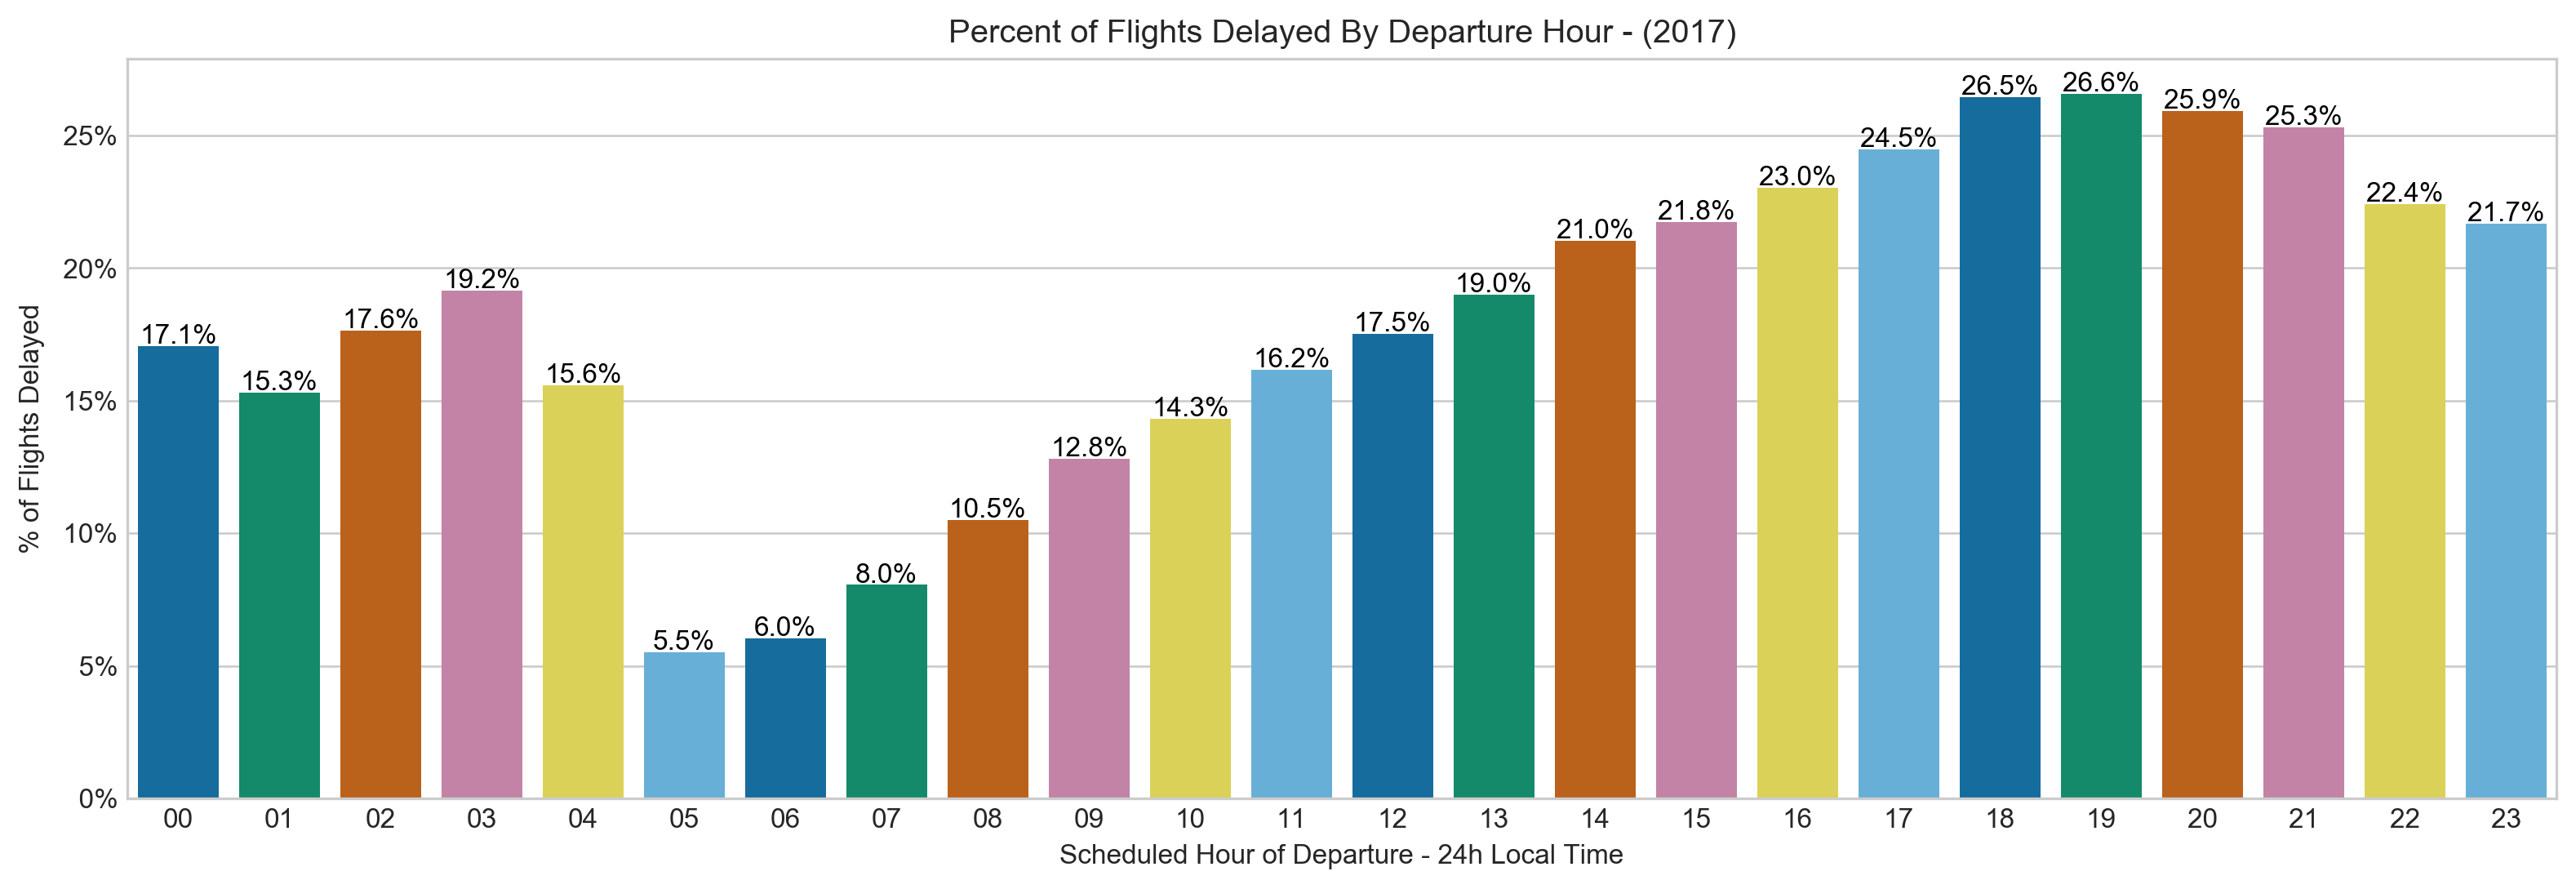

In [5]:
def plot_rate_of_delays_by_hour(data):
    color = sns.color_palette('colorblind')
    fig, ax = plt.subplots(figsize=(16, 5), dpi=240)
    ax = sns.barplot(ax=ax, x='departure_hour', y='fraction_delayed', data=data, palette=color)

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    for p in ax.patches:
        height = p.get_height()
        label_string = '{:2.1f}%'.format(height * 100)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 1e-3,
                label_string,
                ha="center", color='black') 

    plt.title('Percent of Flights Delayed By Departure Hour - (2017)')
    plt.xlabel('Scheduled Hour of Departure - 24h Local Time')
    plt.ylabel('% of Flights Delayed')
    plt.savefig("../../reports/figures/rates-of-delay-by-hour-of-departure.png", bbox_inches='tight')
    plt.show()
    
plot_rate_of_delays_by_hour(hour_of_departure)

## What hours of departure experience a higher rate of delay?

For 2017, the lowest rates of delayed departures were in the early morning hours (5:00 am to 9:00 am), as the day progresses the percentage of delayed flights increasesd.  One hypothesis for such a trend is that delays that occur earlier in the day may have a cascading effect and delay the next scheduled departure for that plane.